So, we are using ISCE2 for generating IFGs and we will process the geographic extents of a specified frame. The frames that are generated previously are grouped by *time* - that is we ensure a frame contains all the bursts that were imaged at the same time. However, when processing with ISCE2, we are only able to group bursts *geographically*, specifically, ISCE2 accepts a region of interest. The range direction of the image is constrained by the track. However, the azimuth direction of our frames need to be further constrained by latitude if there is going to be good agreement between our frame definition and what we see in our GUNW.

This notebook will generate two additional datasets.

1. Latitude aligned frames - these are frames whose North/South boundaries are aligned with a latitude line. This ensures that the GUNW processing will be better aligned with our frame definition.
2. Expected GUNW extents for a given frame - the true extent of the GUNW if we have our region of interest dictated by a latitude aligned frame. This will generally be slightly larger than the frame definition.

Note the Latitude-aligned frame will be a parallelogram with it's north/south edges aligned with a latitude line. When submitting the bounding box of this frame to ISCE2, we will get all the bursts that overlap this frame, so the expected GUNW will be *larger* than the frame definition. Even though our frames have a specified number of burst overlaps, there will likely be more overlap for this reason. Note the latitude aligned frames north/south edge overlaps its neighboring frame by only $\approx$1 GUNW pixel ($\approx$110 meters at the equator). Furthermore, we will want to keep track of both these datasets because the latter will necessary to specify the DEM extents (because we want DEM over all bursts that will be processed). Also, it will be helpful to see how the GUNWs submitted with these frames actually look.

In [1]:
import sqlite3
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd
from rasterio.crs import CRS
import warnings
from shapely import Polygon
from zip_io import to_geojson_zip
from dateline import dateline_frame_fix

/var/folders/s6/fbsc26cd0ddffbp3_knts_9c0wcxj1/T/ipykernel_6362/2999978722.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


# Parameters

How the frames will overlap in latitude.

In [2]:
OVERLAP_DEGREES_LATITUDE = .001
SIMPLIFY_TOLERANCE = .001

# Read Burst Data

The data needs to be unzipped first in this directory.

In [3]:
%%time

# SQL must wrap the geometry in hex(st_asbinary(...))
sql = "SELECT * FROM burst_id_map;"
con = sqlite3.connect("S1_burstid_20220530/IW/sqlite/burst_map_IW_000001_375887.sqlite3")

df_burst = gpd.GeoDataFrame.from_postgis(sql, con, geom_col="GEOMETRY")

CPU times: user 8.86 s, sys: 828 ms, total: 9.68 s
Wall time: 9.68 s


In [4]:
df_burst['relative_orbit_number_min'] = df_burst['relative_orbit_number']
df_burst['relative_orbit_number_max'] = df_burst['relative_orbit_number']

In [5]:
df_burst.head()

,OGC_FID,GEOMETRY,burst_id,subswath_name,relative_orbit_number,time_from_anx_sec,orbit_pass,relative_orbit_number_min,relative_orbit_number_max
0,1,"MULTIPOLYGON Z (((3.36758 0.75322 0.00000, 3.7...",1,IW1,1,2.301015,ASCENDING,1,1
1,2,"MULTIPOLYGON Z (((4.09178 0.97402 0.00000, 4.5...",1,IW2,1,3.133218,ASCENDING,1,1
2,3,"MULTIPOLYGON Z (((4.85545 1.19200 0.00000, 5.2...",1,IW3,1,4.211255,ASCENDING,1,1
3,4,"MULTIPOLYGON Z (((3.33269 0.92005 0.00000, 3.7...",2,IW1,1,5.059288,ASCENDING,1,1
4,5,"MULTIPOLYGON Z (((4.05690 1.14071 0.00000, 4.4...",2,IW2,1,5.891491,ASCENDING,1,1


So there is an important caveat in our approach. We want to carry out our geometric manipulations and still have the dateline corrections we had previously applied for our burst aligned frames (it's too hard to re-apply the same corrections without additional accounting/work). Since we perform the intersection using the bursts, we will just copy the bursts to the right and left of the -180/180 marks respectively, creating a slightly expanded dataframe, and use this for intersection.

In [6]:
df_burst_l = df_burst.cx[170:,:].copy()
df_burst_l.geometry = df_burst_l.geometry.translate(xoff=-360, yoff=0)

df_burst_r = df_burst.cx[:-170,:].copy()
df_burst_r.geometry = df_burst_r.geometry.translate(xoff=360, yoff=0)

df_burst_large = pd.concat([df_burst,
                            df_burst_l,
                            df_burst_r], axis=0).reset_index(drop=True)

df_burst_large.head()

,OGC_FID,GEOMETRY,burst_id,subswath_name,relative_orbit_number,time_from_anx_sec,orbit_pass,relative_orbit_number_min,relative_orbit_number_max
0,1,"MULTIPOLYGON Z (((3.36758 0.75322 0.00000, 3.7...",1,IW1,1,2.301015,ASCENDING,1,1
1,2,"MULTIPOLYGON Z (((4.09178 0.97402 0.00000, 4.5...",1,IW2,1,3.133218,ASCENDING,1,1
2,3,"MULTIPOLYGON Z (((4.85545 1.19200 0.00000, 5.2...",1,IW3,1,4.211255,ASCENDING,1,1
3,4,"MULTIPOLYGON Z (((3.33269 0.92005 0.00000, 3.7...",2,IW1,1,5.059288,ASCENDING,1,1
4,5,"MULTIPOLYGON Z (((4.05690 1.14071 0.00000, 4.4...",2,IW2,1,5.891491,ASCENDING,1,1


# Reading our Burst-aligned Frames

From the previous notebook.

In [7]:
df_burst_frame = gpd.read_file('s1_frames.geojson.zip')

In [8]:
df_burst_frame.head()

,frame_id,OGC_FID_min,OGC_FID_max,burst_id_min,burst_id_max,relative_orbit_number_min,relative_orbit_number_max,orbit_direction,geometry
0,0,22,45,8,15,1,1,ASCENDING,"POLYGON Z ((3.08906 2.08797 0.00000, 3.08720 2..."
1,1,43,66,15,22,1,1,ASCENDING,"POLYGON Z ((2.84448 3.25558 0.00000, 2.84448 3..."
2,2,64,87,22,29,1,1,ASCENDING,"POLYGON Z ((2.60090 4.42328 0.00000, 2.60090 4..."
3,3,85,108,29,36,1,1,ASCENDING,"POLYGON Z ((2.35832 5.59108 0.00000, 2.35832 5..."
4,4,106,129,36,43,1,1,ASCENDING,"POLYGON Z ((2.11654 6.75894 0.00000, 2.11653 6..."


# Generating Latitude-aligned Frames

The bursts (within an image and our fixed frames) are grouped according to `OGC_FID // 3` (same integer quotient after division by 3). Further, the middle `OGC_FID` of `3n`, `3n+1`, `3n+2` is in the center of the 3 swaths. So, we will take the centroid of this middle burst (`3n+1`) and use that to draw a latitude line at the bottom and top of the frames we previously defined. Our final frame will be an envelope (i.e. axis-aligned rectangle in `shapely` speak) around the frame with latitude top/bottom line. From there, we interesect this box with the frame. We importantly note the burst frames are multipolygons at the dateline. However, we only want the *y* value, which is valued even if the geometries are "wrapped" around the dateline. That is the y-value of the centroid will be the same for a burst even it is a multipolygon around the dateline. Therefore, we can use the original bursts directly to look up the centroid. This is still very fast and no extra accounting needed.

In [9]:
# We only want to lookup from the original burst dataset since we are interested in the y-coord of the centroid
# Even if they are multipolygons, 
df_burst_ogc = df_burst.set_index('OGC_FID')

In [10]:
centroid_min = df_burst_frame.OGC_FID_min.map(lambda ogc_fid: df_burst_ogc.loc[ogc_fid + 1].GEOMETRY.centroid)
centroid_max = df_burst_frame.OGC_FID_max.map(lambda ogc_fid: df_burst_ogc.loc[ogc_fid - 1].GEOMETRY.centroid)

In [11]:
centroid_min_y = centroid_min.map(lambda geo: geo.coords[0][1])
centroid_max_y = centroid_max.map(lambda geo: geo.coords[0][1])

In [12]:
df_burst_frame['centroid_min_y'] = centroid_min_y
df_burst_frame['centroid_max_y'] = centroid_max_y

In [13]:
df_burst_centroid = df_burst_frame.copy()
df_burst_centroid.geometry = centroid_min

In [14]:
def comp_top(row):
    min_y = row['centroid_min_y']
    max_y = row['centroid_max_y']
    return min_y if min_y >= max_y else max_y

def comp_bot(row):
    min_y = row['centroid_min_y']
    max_y = row['centroid_max_y']
    return min_y if min_y <= max_y else max_y

df_burst_frame['top_y'] = df_burst_frame.apply(comp_top, axis=1)
df_burst_frame['bot_y'] = df_burst_frame.apply(comp_bot, axis=1)
df_bounds = df_burst_frame.bounds
df_burst_frame['xmin'] = df_bounds.minx - 2
df_burst_frame['xmax'] = df_bounds.maxx + 2

In [15]:
def get_yaxis_envelope(row, longitude_buffer=3):
    geo = row['geometry']
    top_y = row['top_y']
    bot_y = row['bot_y']
    
    xmin = row['xmin']
    xmax = row['xmax']
    
    geo = geo.minimum_rotated_rectangle
    center_rect_x = geo.centroid.coords[0][0]
    coords = geo.exterior.coords[:]
    coords_clipped = [(c[0] - longitude_buffer if c[0] <= center_rect_x else c[0] + longitude_buffer, 
                       np.clip(c[1], 
                               bot_y - OVERLAP_DEGREES_LATITUDE, 
                               top_y + OVERLAP_DEGREES_LATITUDE))
                      for c in coords]
    return Polygon(coords_clipped).envelope

df_burst_frame_envelope = df_burst_frame.copy()
df_burst_frame_envelope.geometry = df_burst_frame_envelope.apply(get_yaxis_envelope, axis=1)

<AxesSubplot: >

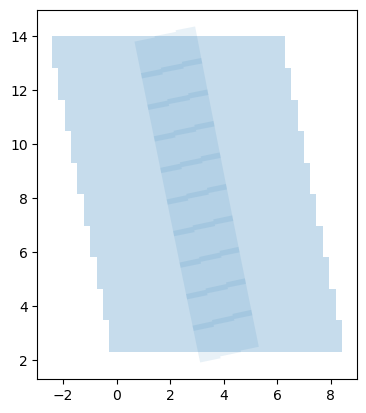

In [16]:
fig, ax = plt.subplots()
df_burst_frame_envelope.iloc[:10].plot(alpha=.25, ax=ax)
df_burst_frame.iloc[:10].plot(alpha=.1, ax=ax)

In [17]:
%%time

from shapely import STRtree

tree_frames = STRtree(df_burst_frame.geometry)
tree_bursts = STRtree(df_burst_large.geometry)

CPU times: user 22.4 s, sys: 538 ms, total: 23 s
Wall time: 22 s


In [18]:
%%time

def intersection_with_bursts(row):
    geo = row['geometry']
    idxs = tree_bursts.query(geo, predicate="intersects")
    df_temp = df_burst_large.iloc[idxs].reset_index(drop=True)
    
    track_min = row['relative_orbit_number_min']
    track_max = row['relative_orbit_number_max']
    
    ind_min = df_temp.relative_orbit_number >= track_min
    ind_max = df_temp.relative_orbit_number <= track_max
    df_temp = df_temp[ind_min & ind_max].reset_index(drop=True)
    
    overlapping_bursts = df_temp.geometry.unary_union
    return overlapping_bursts.intersection(geo)

df_burst_frame_latitude_aligned = df_burst_frame_envelope.copy()
df_burst_frame_latitude_aligned.geometry = df_burst_frame_envelope.apply(intersection_with_bursts, axis=1)

CPU times: user 1min 32s, sys: 214 ms, total: 1min 32s
Wall time: 1min 32s


<AxesSubplot: >

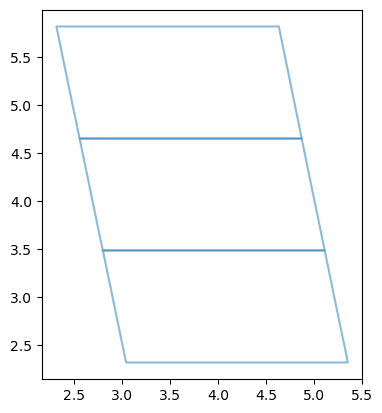

In [19]:
df_burst_frame_latitude_aligned.boundary.iloc[:3].plot(alpha=.5)

In [20]:
columns = ['frame_id', 
           'relative_orbit_number_min',
           'relative_orbit_number_max',
           'orbit_direction',
           'geometry']
df_burst_frame_latitude_aligned_final = df_burst_frame_latitude_aligned[columns].copy()
# This vastly reduces the filesize of the file - parallelogram geometries are simple as well
df_burst_frame_latitude_aligned_final.geometry = df_burst_frame_latitude_aligned_final.geometry.simplify(SIMPLIFY_TOLERANCE)
df_burst_frame_latitude_aligned_final = df_burst_frame_latitude_aligned_final.sort_values(by='frame_id')
df_burst_frame_latitude_aligned_final = df_burst_frame_latitude_aligned_final.reset_index(drop=True)
df_burst_frame_latitude_aligned_final.head()

,frame_id,relative_orbit_number_min,relative_orbit_number_max,orbit_direction,geometry
0,0,1,1,ASCENDING,"POLYGON Z ((3.01777 2.42129 0.00000, 2.79632 3..."
1,1,1,1,ASCENDING,"POLYGON Z ((2.77387 3.58901 0.00000, 2.55373 4..."
2,2,1,1,ASCENDING,"POLYGON Z ((2.53190 4.75701 0.00000, 2.49742 4..."
3,3,1,1,ASCENDING,"POLYGON Z ((2.28948 5.92481 0.00000, 2.07018 6..."
4,4,1,1,ASCENDING,"POLYGON Z ((2.04783 7.09267 0.00000, 1.82942 8..."


# Serialize

In [21]:
# df_burst_frame_latitude_aligned_final.to_file('s1_frames_latitude_aligned.geojson', driver='GeoJSON')

The file above is less than 20 MB as a geojson. So compression not really needed - it's nice to keep things small for version control. Gzip (i.e. `ZIP_DEFLATED`) works as a good compression method. I haven't done any research into comparing compression methods nor am I familiar with the various python standard library compression methods/tools. Got it to work and significantly reduced size to <4 MB. Sticking with this. Moreover, `geopandas` and QGIS can read zip files directly!

In [22]:
to_geojson_zip(df_burst_frame_latitude_aligned_final, 's1_frames_latitude_aligned.geojson.zip')

# Illustrating that the above compressed file can be read through geopandas
# df_test = gpd.read_file('s1_frames_latitude_aligned.geojson.zip')

's1_frames_latitude_aligned.geojson.zip'

# What do our GUNWs look Like?

So, during ISCE2 processing, the extent of the GUNW will be determined by taking all bursts that *intersect* the region of interest, which is based on the bounding box around a frame (only option is to specify a bounding box). The top and bottom of the frame will intersect numerous bursts that are not entirely contained in the frame itself and therefore the GUNW extent will go beyond the frame. Further, we should know the expected GUNW extent during the processing because we will want the extent of the DEM to request.

## Samples

In [23]:
K = 1000 #19910 #1000 
T = 3

gunws = []
for t in range(T):

    sample_frame = df_burst_frame_latitude_aligned.iloc[K + t]
    geo_frame = sample_frame.geometry.envelope
    # Near the equator, we can have frames with multiple tracks/relative orbit numbers
    track_min = sample_frame['relative_orbit_number_min']
    track_max = sample_frame['relative_orbit_number_max']
    tracks = [track_min, track_max]
    
    sample_idxs = tree_bursts.query(geo_frame, predicate="intersects")
    df_gunw = df_burst_large.iloc[sample_idxs].reset_index(drop=True)
    df_gunw = df_gunw[df_gunw.relative_orbit_number.isin(tracks)].copy()
    df_gunw = df_gunw.dissolve()
    gunws.append(df_gunw)
    
df_gunw_neighbor = pd.concat(gunws, axis=0).reset_index(drop=True)

(16.606232, 23.906067)

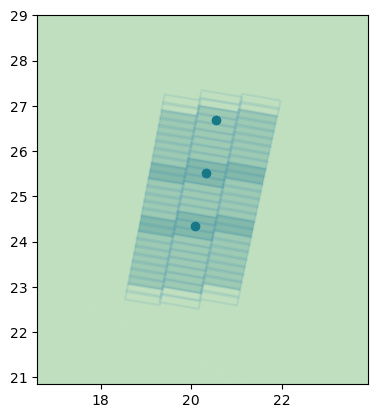

In [24]:
fig, ax= plt.subplots()
df_gunw_neighbor.plot(alpha=.2, ax=ax)
df_burst_centroid.iloc[K: K+T].plot(ax =ax)

df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
xmin, ymin, xmax, ymax = df_gunw_neighbor.total_bounds
df_world.plot(ax=ax, color='green',alpha=.25)


df_burst_p = df_burst.cx[xmin: xmax, ymin: ymax]
df_burst_p = df_burst_p[df_burst_p.relative_orbit_number_min == track_min]
df_burst_p.boundary.plot(ax=ax, alpha=.1)

ax.set_ylim(ymin-2, ymax+2)
ax.set_xlim(xmin-2, xmax+2)

## Automate 

In [25]:
def get_slice(k, row):
    geo_frame = row['geometry'].envelope
    
    # Near the equator, we can have frames with multiple tracks/relative orbit numbers
    track_min = row['relative_orbit_number_min']
    track_max = row['relative_orbit_number_max']
    tracks = [track_min, track_max]
    frame_id = row['frame_id']
    
    idxs = tree_bursts.query(geo_frame, predicate="intersects")
    df_slice = df_burst_large.iloc[idxs].copy()
    
    df_slice = df_slice[df_slice.relative_orbit_number.isin(tracks)].reset_index(drop=True)
    df_slice['slice_index'] = k
    df_slice['frame_id'] = frame_id
    return df_slice

In [26]:
df_slices = [get_slice(k, row) for k, row in tqdm(df_burst_frame_latitude_aligned.iterrows(),
                                                  total=df_burst_frame_latitude_aligned.shape[0])]

100%|██████████████| 27563/27563 [00:57<00:00, 475.38it/s]


In [27]:
df_slice = pd.concat(df_slices, axis=0)
df_slice.head()

,OGC_FID,GEOMETRY,burst_id,subswath_name,relative_orbit_number,time_from_anx_sec,orbit_pass,relative_orbit_number_min,relative_orbit_number_max,slice_index,frame_id
0,25,"MULTIPOLYGON Z (((3.08720 2.08759 0.00000, 3.4...",9,IW1,1,24.367199,ASCENDING,1,1,0,0
1,28,"MULTIPOLYGON Z (((3.05247 2.25444 0.00000, 3.4...",10,IW1,1,27.125471,ASCENDING,1,1,0,0
2,20,"MULTIPOLYGON Z (((3.88291 1.97419 0.00000, 4.2...",7,IW2,1,19.682856,ASCENDING,1,1,0,0
3,18,"MULTIPOLYGON Z (((4.68163 2.02457 0.00000, 5.0...",6,IW3,1,18.002620,ASCENDING,1,1,0,0
4,23,"MULTIPOLYGON Z (((3.84820 2.14090 0.00000, 4.2...",8,IW2,1,22.441128,ASCENDING,1,1,0,0


In [28]:
df_slice = df_slice[['slice_index', 'GEOMETRY', 'frame_id']]
df_slice = df_slice.rename(columns={'GEOMETRY':'geometry'})
df_slice = df_slice.set_geometry("geometry")
df_slice = df_slice.set_crs(CRS.from_epsg(4326))
df_slice.head()

,slice_index,geometry,frame_id
0,0,"MULTIPOLYGON Z (((3.08720 2.08759 0.00000, 3.4...",0
1,0,"MULTIPOLYGON Z (((3.05247 2.25444 0.00000, 3.4...",0
2,0,"MULTIPOLYGON Z (((3.88291 1.97419 0.00000, 4.2...",0
3,0,"MULTIPOLYGON Z (((4.68163 2.02457 0.00000, 5.0...",0
4,0,"MULTIPOLYGON Z (((3.84820 2.14090 0.00000, 4.2...",0


In [29]:
# %%time
# df_frame_gunw_extent = df_slice.dissolve(by='slice_index')

In [30]:
import dask_geopandas

df_slice_dask = dask_geopandas.from_geopandas(df_slice, npartitions=10)
df_slice_dask.head()

,slice_index,geometry,frame_id
0,0,"MULTIPOLYGON Z (((3.08720 2.08759 0.00000, 3.4...",0
0,6649,"MULTIPOLYGON Z (((16.00672 32.96548 0.00000, 1...",6683
0,6650,"MULTIPOLYGON Z (((16.71604 34.15339 0.00000, 1...",6684
0,24126,"MULTIPOLYGON Z (((-63.88617 -9.36496 0.00000, ...",24274
0,6651,"MULTIPOLYGON Z (((16.47272 35.31537 0.00000, 1...",6685


In [31]:
df_frames_0 = df_slice_dask.dissolve(by='slice_index')
df_frames_0

,frame_id,geometry
npartitions=1,,
,int64,geometry
,...,...


In [32]:
%%time

df_frame_gunw_extent = df_frames_0.compute()
df_frame_gunw_extent = df_frame_gunw_extent.sort_values(by='frame_id').reset_index(drop=True)
df_frame_gunw_extent.head()

CPU times: user 1min 32s, sys: 6.4 s, total: 1min 38s
Wall time: 1min 6s


,frame_id,geometry
0,0,"POLYGON Z ((3.05247 2.25444 0.00000, 3.04886 2..."
1,1,"POLYGON Z ((3.60452 3.30760 0.00000, 3.60452 3..."
2,2,"POLYGON Z ((2.52949 4.76867 0.00000, 2.52612 4..."
3,3,"POLYGON Z ((3.95778 5.52153 0.00000, 3.93528 5..."
4,4,"POLYGON Z ((2.87933 6.81681 0.00000, 2.87750 6..."


# Visualization

In [33]:
K = 20_000

In [34]:
df_frame_gunw_extent.head()

,frame_id,geometry
0,0,"POLYGON Z ((3.05247 2.25444 0.00000, 3.04886 2..."
1,1,"POLYGON Z ((3.60452 3.30760 0.00000, 3.60452 3..."
2,2,"POLYGON Z ((2.52949 4.76867 0.00000, 2.52612 4..."
3,3,"POLYGON Z ((3.95778 5.52153 0.00000, 3.93528 5..."
4,4,"POLYGON Z ((2.87933 6.81681 0.00000, 2.87750 6..."


<AxesSubplot: >

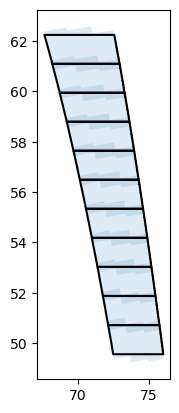

In [39]:
fig, ax = plt.subplots()
s = np.s_[K: K+10]
df_frame_gunw_extent.set_index('frame_id').loc[s].plot(alpha=.14, ax=ax)
df_burst_frame_latitude_aligned.set_index('frame_id').loc[s].boundary.plot(color='black', ax=ax)

In [36]:
df_frame_gunw_extent.set_index('frame_id').loc[s].index

Int64Index([20000, 20001, 20002, 20003, 20004, 20005, 20006, 20007, 20008,
            20009, 20010, 20011, 20012, 20013, 20014, 20015, 20016, 20017,
            20018, 20019, 20020],
           dtype='int64', name='frame_id')

In [37]:
df_burst_frame_latitude_aligned.set_index('frame_id').loc[s].index

Int64Index([20000, 20001, 20002, 20003, 20004, 20005, 20006, 20007, 20008,
            20009, 20010, 20011, 20012, 20013, 20014, 20015, 20016, 20017,
            20018, 20019, 20020],
           dtype='int64', name='frame_id')

# Serialization

For the GUNW plugin:

In [38]:
# df_frame_gunw_extent.to_file('s1_frames_latitude_aligned_gunw_footprint.geojson')
to_geojson_zip(df_frame_gunw_extent, 's1_gunw_frame_footprints.geojson.zip')

's1_gunw_frame_footprints.geojson.zip'